In [ ]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=d9a03b629e9b9a68d382e4e43ff321cb49286fe6c5153c9b6ebfb610d341ae3e
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


# Part 1: Load Data

Our raw data contains the details of a singular chess game. Our focus is on the move sequence (which we would use to construct game states) and player information (ELO).

In [41]:
import pandas as pd
import chess

def load_chess_data(filepath, nrows=None):
    """
    Load chess game data from a CSV file into a Pandas DataFrame. By default, the entire file is loaded.

    Args:
        filepath (str): The path to the CSV file.
        nrows (int, optional): The number of rows to load. If None, the entire file is loaded.

    Returns:
        pd.DataFrame: The loaded DataFrame containing the chess data.
    """
    try:
        # Load the CSV file, either all rows or the first nrows rows
        df = pd.read_csv(filepath, nrows=nrows)

        # Ensure required columns are present
        required_columns = ['winner', 'white_rating', 'black_rating', 'moves',
                            'opening_eco', 'opening_name', 'opening_ply']
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"Missing required columns in the CSV file: {missing_columns}")

        print(f"CSV file loaded successfully with {len(df)} rows.")
        return df

    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None

# Load the entire CSV file or specify the number of rows
file_path = "games.csv"
chess_df = load_chess_data(file_path)

if chess_df is not None:
    print(chess_df.head())

CSV file loaded successfully with 20058 rows.
         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.500000e+12  1.500000e+12     13      outoftime  white   
1  l1NXvwaE   True  1.500000e+12  1.500000e+12     16         resign  black   
2  mIICvQHh   True  1.500000e+12  1.500000e+12     61           mate  white   
3  kWKvrqYL   True  1.500000e+12  1.500000e+12     61           mate  white   
4  9tXo1AUZ   True  1.500000e+12  1.500000e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                

# Part 2: Game State Construction and Data Engineering

We want to make a prediction of a winner (white win percentage) based on a particular board state. To extract the board states, we extract every single board state from each game, using the sequences of moves.

We then calculate certain parameters from the game state.

In [42]:
import chess
import chess.pgn
import pandas as pd
import re
from collections import Counter
from tqdm import tqdm

def calculate_piece_differential(board):
    piece_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9,
        chess.KING: 0  # Assign 0 value to the King
    }
    white_value = sum(
        piece_values.get(piece.piece_type, 0)
        for piece in board.piece_map().values()
        if piece.color == chess.WHITE
    )
    black_value = sum(
        piece_values.get(piece.piece_type, 0)
        for piece in board.piece_map().values()
        if piece.color == chess.BLACK
    )
    return white_value - black_value

def calculate_elo_diff(df):
    """
    Calculate the Elo difference (white_rating - black_rating).

    Args:
        df (pd.DataFrame): The chess dataset.

    Returns:
        pd.DataFrame: Updated DataFrame with the 'elo_diff' column.
    """
    df['elo_diff'] = df['white_rating'] - df['black_rating']
    return df

def calculate_mobility(board):
    """
    Calculate the mobility difference (white_moves - black_moves).

    Args:
        board (chess.Board): The current game state.

    Returns:
        int: The difference in the number of legal moves.
    """
    original_turn = board.turn
    board.turn = chess.WHITE
    white_moves = len(list(board.legal_moves))
    board.turn = chess.BLACK
    black_moves = len(list(board.legal_moves))
    board.turn = original_turn  # Restore the original turn
    return white_moves - black_moves

def calculate_king_safety(board):
    """
    Calculate the king safety differential.

    Args:
        board (chess.Board): The current game state.

    Returns:
        float: The difference in king safety scores (white - black).
    """
    def king_safety_for_color(color):
        king_square = board.king(color)
        safety_score = 0

        # Check if the king is castled
        if color == chess.WHITE:
            if king_square == chess.E1:
                safety_score -= 1  # Less safe if not castled
            elif king_square in [chess.G1, chess.C1]:
                safety_score += 1  # More safe if castled
        else:
            if king_square == chess.E8:
                safety_score -= 1
            elif king_square in [chess.G8, chess.C8]:
                safety_score += 1

        # Check for pawn shield around the king
        pawn_shield_squares = []
        if color == chess.WHITE:
            if king_square == chess.G1:
                pawn_shield_squares = [chess.F2, chess.G2, chess.H2]
            elif king_square == chess.C1:
                pawn_shield_squares = [chess.A2, chess.B2, chess.C2]
            else:
                pawn_shield_squares = [chess.D2, chess.E2, chess.F2]
        else:
            if king_square == chess.G8:
                pawn_shield_squares = [chess.F7, chess.G7, chess.H7]
            elif king_square == chess.C8:
                pawn_shield_squares = [chess.A7, chess.B7, chess.C7]
            else:
                pawn_shield_squares = [chess.D7, chess.E7, chess.F7]

        for square in pawn_shield_squares:
            piece = board.piece_at(square)
            if piece and piece.piece_type == chess.PAWN and piece.color == color:
                safety_score += 0.5
            else:
                safety_score -= 0.5

        return safety_score

    white_king_safety = king_safety_for_color(chess.WHITE)
    black_king_safety = king_safety_for_color(chess.BLACK)
    return white_king_safety - black_king_safety

def get_game_phase(turn_number):
    """
    Determine the game phase based on the turn number.

    Args:
        turn_number (int): The current turn number.

    Returns:
        dict: One-hot encoded game phase.
    """
    if turn_number <= 15:
        return {'opening': 1, 'middle_game': 0, 'endgame': 0}
    elif turn_number <= 40:
        return {'opening': 0, 'middle_game': 1, 'endgame': 0}
    else:
        return {'opening': 0, 'middle_game': 0, 'endgame': 1}

def calculate_pawn_structure(board):
    """
    Calculate pawn structure metrics like doubled and isolated pawns.

    Args:
        board (chess.Board): The current game state.

    Returns:
        dict: Differences in pawn structure metrics (white - black).
    """
    def pawn_structure_for_color(color):
        pawns = board.pieces(chess.PAWN, color)
        files_with_pawns = [chess.square_file(square) for square in pawns]
        file_counts = Counter(files_with_pawns)

        # Doubled pawns: files with more than one pawn
        doubled_pawns = sum(1 for count in file_counts.values() if count > 1)

        # Isolated pawns: pawns with no friendly pawns on adjacent files
        isolated_pawns = 0
        for file in file_counts:
            adjacent_files = [file - 1, file + 1]
            has_adjacent_pawn = any(
                adj_file in file_counts for adj_file in adjacent_files if 0 <= adj_file <= 7
            )
            if not has_adjacent_pawn:
                isolated_pawns += file_counts[file]

        return {'doubled_pawns': doubled_pawns, 'isolated_pawns': isolated_pawns}

    white_pawn_structure = pawn_structure_for_color(chess.WHITE)
    black_pawn_structure = pawn_structure_for_color(chess.BLACK)

    pawn_structure_diff = {
        'doubled_pawns_diff': white_pawn_structure['doubled_pawns'] - black_pawn_structure['doubled_pawns'],
        'isolated_pawns_diff': white_pawn_structure['isolated_pawns'] - black_pawn_structure['isolated_pawns']
    }
    return pawn_structure_diff

def calculate_control_of_key_squares(board):
    """
    Calculate the difference in control of key squares.

    Args:
        board (chess.Board): The current game state.

    Returns:
        int: Difference in control of key squares (white - black).
    """
    key_squares = [chess.E4, chess.D4, chess.E5, chess.D5]
    white_control = sum(1 for square in key_squares if board.is_attacked_by(chess.WHITE, square))
    black_control = sum(1 for square in key_squares if board.is_attacked_by(chess.BLACK, square))
    return white_control - black_control

In [34]:
def split_game_into_states(df):
    """
    Split games into states and calculate state-level features, including the target variable y.

    Args:
        df (pd.DataFrame): The chess dataset.

    Returns:
        pd.DataFrame: A DataFrame with game states and their features.
    """
    states = []
    total_games = len(df)
    print(f"Processing {total_games} games...")

    # Use tqdm to wrap the iterator for the progress bar
    for index, row in tqdm(df.iterrows(), total=total_games, desc="Processing games"):
        game_id = row.get('id', index)
        moves_str = row['moves']
        elo_diff = row['elo_diff']
        winner = row['winner']

        # Remove move numbers and annotations
        moves_str = re.sub(r'\d+\.', '', moves_str)
        moves_str = re.sub(r'\{[^}]*\}', '', moves_str)
        moves_str = moves_str.strip()
        moves = moves_str.split()

        total_turns = len(moves)  # Total number of moves in the game

        board = chess.Board()
        for turn_number, move in enumerate(moves, start=1):
            try:
                board.push_san(move)
                fen = board.fen()
                piece_diff = calculate_piece_differential(board)

                # Calculate additional features
                mobility = calculate_mobility(board)
                king_safety = calculate_king_safety(board)
                game_phase = get_game_phase(turn_number)
                pawn_structure = calculate_pawn_structure(board)
                control_of_key_squares = calculate_control_of_key_squares(board)

                # Calculate the target variable y
                if winner == 'white':
                    y = 0.5 + 0.5 * (turn_number / total_turns)
                elif winner == 'black':
                    y = 0.5 - 0.5 * (turn_number / total_turns)
                else:  # For draws or other outcomes
                    y = 0.5

                state = {
                    # 'game_id': game_id,
                    'turn_number': turn_number,
                    'fen': fen,
                    'piece_diff': piece_diff,
                    'elo_diff': elo_diff,
                    'mobility': mobility,
                    'king_safety': king_safety,
                    'control_of_key_squares': control_of_key_squares,
                    'winner': winner,
                    'y': y  # Add the target variable
                }
                # Merge game_phase and pawn_structure into the state
                state.update(game_phase)
                state.update(pawn_structure)
                states.append(state)

            except Exception as e:
                print(f"Error processing move '{move}' in game {game_id}: {type(e).__name__}: {e}")
                break
    return pd.DataFrame(states)

def process_chess_data(df):
    """
    Process the chess data to calculate game and state-level features.

    Args:
        df (pd.DataFrame): The chess dataset.

    Returns:
        pd.DataFrame: A DataFrame with game states and their features.
    """
    df = calculate_elo_diff(df)
    game_states = split_game_into_states(df)
    return game_states

In [43]:
if chess_df is not None:
    # Process the data
    game_states = process_chess_data(chess_df)

    # Save or inspect the results
    output_file = "processed_game_states.csv"
    game_states.to_csv(output_file, index=False)
    print(f"Processed game states saved to {output_file}")
    print(game_states.head())

Processing 20058 games...


Processing games: 100%|██████████| 20058/20058 [10:27<00:00, 31.97it/s]


Processed game states saved to processed_game_states.csv
   turn_number                                                fen  piece_diff  \
0            1  rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR ...           0   
1            2  rnbqkbnr/ppp1pppp/8/3p4/3P4/8/PPP1PPPP/RNBQKBN...           0   
2            3  rnbqkbnr/ppp1pppp/8/3p4/2PP4/8/PP2PPPP/RNBQKBN...           0   
3            4  rnbqkbnr/pp2pppp/2p5/3p4/2PP4/8/PP2PPPP/RNBQKB...           0   
4            5  rnbqkbnr/pp2pppp/2p5/3P4/3P4/8/PP2PPPP/RNBQKBN...           1   

   elo_diff  mobility  king_safety  control_of_key_squares winner         y  \
0       309         8         -1.0                       2  white  0.538462   
1       309         0          0.0                       0  white  0.576923   
2       309         2          0.0                       1  white  0.615385   
3       309         1          0.0                       1  white  0.653846   
4       309         0          0.0                       1  w

# Part 3: Train the model

CNN.

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import csv

# Load processed game states DataFrame
game_states = pd.read_csv("processed_game_states.csv")
print(f"Loaded {len(game_states)} game states.")

# Function to convert FEN to tensor
def fen_to_tensor(fen):
    piece_to_index = {
        'P': 0,  'N': 1,  'B': 2,  'R': 3,  'Q': 4,  'K': 5,
        'p': 6,  'n': 7,  'b': 8,  'r': 9,  'q': 10, 'k': 11
    }
    board_tensor = np.zeros((8, 8, 12), dtype=int)
    fen_board = fen.split(' ')[0]
    rows = fen_board.split('/')
    for row_idx, row in enumerate(rows):
        col_idx = 0
        for char in row:
            if char.isdigit():
                col_idx += int(char)
            else:
                piece_idx = piece_to_index[char]
                board_tensor[row_idx, col_idx, piece_idx] = 1
                col_idx += 1
    return board_tensor

# Convert FEN to tensors
print("Converting FEN to tensors...")
tqdm.pandas()
board_tensors = game_states['fen'].progress_apply(fen_to_tensor)
X_board = np.stack(board_tensors.to_numpy())

Loaded 1212827 game states.
Converting FEN to tensors...


100%|██████████| 1212827/1212827 [00:15<00:00, 76986.59it/s]


2024-11-25 13:57:13.950783: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 13:57:14.596272: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 13:57:22.504172: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30872 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:18:00.0, compute capability: 7.0


Epoch 1/60


2024-11-25 13:57:31.115285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-11-25 13:57:31.887150: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561c2f3d9ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-25 13:57:31.887178: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-11-25 13:57:31.992060: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-25 13:57:32.822273: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30321/30321 [==============================] - ETA: 0s - loss: 0.0416 - mean_squared_error: 0.0416
New best model saved at epoch 1 with val_loss: 0.0296
30321/30321 [==============================] - 117s 4ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 2/60
   35/30321 [..............................] - ETA: 1:33 - loss: 0.0267 - mean_squared_error: 0.0267

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30321/30321 [==============================] - ETA: 0s - loss: 0.0224 - mean_squared_error: 0.0224
New best model saved at epoch 2 with val_loss: 0.0197
30321/30321 [==============================] - 106s 4ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 3/60
30319/30321 [============================>.] - ETA: 0s - loss: 0.0152 - mean_squared_error: 0.0152
New best model saved at epoch 3 with val_loss: 0.0157
30321/30321 [==============================] - 109s 4ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 4/60
30321/30321 [==============================] - ETA: 0s - loss: 0.0119 - mean_squared_error: 0.0119
New best model saved at epoch 4 with val_loss: 0.0138
30321/30321 [==============================] - 109s 4ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 5/60
30320/30321 [========================

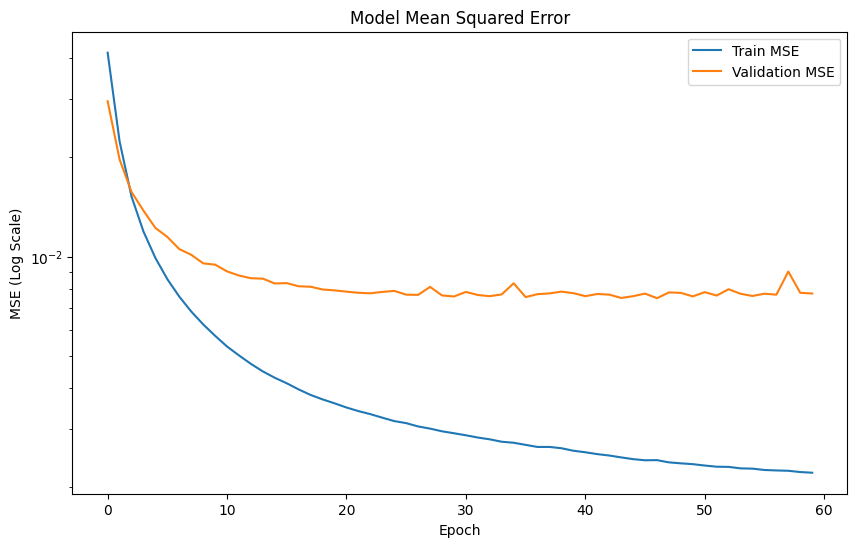

In [2]:
import sys
sys.path.append('/sfs/weka/scratch/ztg5ve/other/project/myenv/lib/python3.11/site-packages') # for chess import - removed for privacy
import chess

import os
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import csv

# Prepare the parameters
parameter_columns = [
    'turn_number', 'elo_diff', 'piece_diff', 'mobility', 'king_safety',
    'control_of_key_squares', 'opening', 'middle_game', 'endgame',
    'doubled_pawns_diff', 'isolated_pawns_diff'
]
X_params = game_states[parameter_columns].fillna(0).astype(np.float32).to_numpy()

# Create scalers for specific columns
turn_number_scaler = MinMaxScaler()  # For `turn_number`
standard_scaler = StandardScaler()  # For most other features

# Split X_params into separate arrays for processing
turn_number = X_params[:, 0].reshape(-1, 1)  # Extract `turn_number`
elo_diff = X_params[:, 1].reshape(-1, 1)  # Extract `elo_diff`
piece_diff = X_params[:, 2].reshape(-1, 1)  # Extract `piece_diff`
king_safety = X_params[:, 3].reshape(-1, 1)  # Extract `king_safety`
doubled_pawns_diff = X_params[:, 9].reshape(-1, 1)  # Extract `doubled_pawns_diff`
isolated_pawns_diff = X_params[:, 10].reshape(-1, 1)  # Extract `isolated_pawns_diff`

# Binary columns: No transformation needed
binary_features = X_params[:, 6:9]  # `opening`, `middle_game`, `endgame`

# Apply scaling
turn_number_scaled = turn_number_scaler.fit_transform(turn_number)
elo_diff_scaled = standard_scaler.fit_transform(elo_diff)
piece_diff_scaled = standard_scaler.fit_transform(piece_diff)
king_safety_scaled = standard_scaler.fit_transform(king_safety)
doubled_pawns_diff_scaled = standard_scaler.fit_transform(doubled_pawns_diff)
isolated_pawns_diff_scaled = standard_scaler.fit_transform(isolated_pawns_diff)

# Recombine scaled features
X_params_scaled = np.hstack([
    turn_number_scaled,
    elo_diff_scaled,
    piece_diff_scaled,
    king_safety_scaled,
    X_params[:, 4:6],  # Retain unscaled features if needed
    binary_features,  # Binary features as-is
    doubled_pawns_diff_scaled,
    isolated_pawns_diff_scaled
])

# Prepare the target variable
y = game_states['y'].astype(np.float32).to_numpy()

# Split the data
X_board_train, X_board_test, X_params_train, X_params_test, y_train, y_test = train_test_split(
    X_board, X_params_scaled, y, test_size=0.2, random_state=42
)

# Define the CNN model
def create_cnn_model():
    board_input = Input(shape=(8, 8, 12), name='board_input')
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same')(board_input)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    return board_input, x

# Define the parameters model
def create_params_model(input_shape):
    params_input = Input(shape=input_shape, name='params_input')
    y = Dense(64, activation='relu')(params_input)
    y = Dense(64, activation='relu')(y)
    return params_input, y

# Create models and combine
board_input, board_output = create_cnn_model()
params_input, params_output = create_params_model((X_params.shape[1],))
combined = Concatenate()([board_output, params_output])
z = Dense(64, activation='relu')(combined)
z = Dense(1, activation='linear')(z)
model = Model(inputs=[board_input, params_input], outputs=z)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'mean_absolute_error'] 
)

# Define model save directory
model_save_dir = 'models_5'
os.makedirs(model_save_dir, exist_ok=True)

# Custom callback to save model every 10 epochs and save the best model
class CustomModelCheckpoint(Callback):
    def __init__(self, save_every_n_epochs, model_save_dir):
        super(CustomModelCheckpoint, self).__init__()
        self.save_every_n_epochs = save_every_n_epochs
        self.model_save_dir = model_save_dir
        self.best_val_loss = float('inf')
        os.makedirs(self.model_save_dir, exist_ok=True) 
        self.best_model_path = os.path.join(self.model_save_dir, 'best_model.h5') 

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        # Save the model every N epochs
        if (epoch + 1) % self.save_every_n_epochs == 0:
            model_path = os.path.join(self.model_save_dir, f'model_epoch_{epoch + 1}.h5')
            self.model.save(model_path)
            print(f'\nModel saved at {model_path}')

        # Save the best model based on validation loss
        current_val_loss = logs.get('val_loss')
        if current_val_loss is not None and current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.model.save(self.best_model_path)
            print(f'\nNew best model saved at epoch {epoch + 1} with val_loss: {current_val_loss:.4f}')

# Instantiate the custom callback
save_every_n_epochs = 10
custom_checkpoint = CustomModelCheckpoint(save_every_n_epochs, model_save_dir)

# Custom callback 2: Save model logs in CSV
class CSVLoggerCallback(Callback):
    def __init__(self, file_path):
        super().__init__()
        self.file_path = file_path
        self.file_initialized = False

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        row = {'epoch': epoch + 1, **logs}  # Include epoch and metrics

        # Write to CSV file
        if not self.file_initialized:
            # Write header if file doesn't exist or for the first time
            with open(self.file_path, 'w', newline='') as f:
                writer = csv.DictWriter(f, fieldnames=row.keys())
                writer.writeheader()
                writer.writerow(row)
            self.file_initialized = True
        else:
            # Append rows for subsequent epochs
            with open(self.file_path, 'a', newline='') as f:
                writer = csv.DictWriter(f, fieldnames=row.keys())
                writer.writerow(row)

# Define the callback
csv_logger = CSVLoggerCallback('training_history_5.csv')

# Train the model with the custom callback
history = model.fit(
    [X_board_train, X_params_train],
    y_train,
    validation_data=([X_board_test, X_params_test], y_test),
    epochs=60, 
    batch_size=32,
    callbacks=[custom_checkpoint, csv_logger]
)

# Evaluate the model
test_loss, test_mse = model.evaluate([X_board_test, X_params_test], y_test)
print(f"Test MSE: {test_mse:.4f}")

# Plot training history on a logarithmic scale and save the plot as an image
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Model Mean Squared Error')
plt.ylabel('MSE (Log Scale)')
plt.xlabel('Epoch')
plt.yscale('log')  # Set y-axis to log scale
plt.legend()
plt.savefig('train_history.png') 
plt.show()


# Part 4: Analysis

(link to csv data)


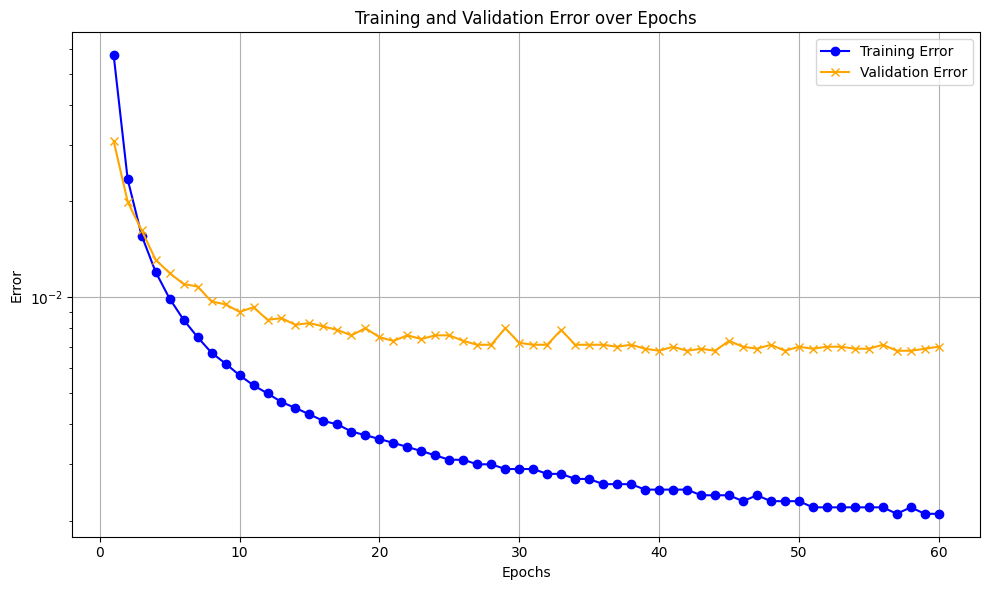

In [2]:
# epochs_data = [
#     (1, 0.0572, 0.0308),
#     (2, 0.0234, 0.0199),
#     (3, 0.0156, 0.0162),
#     (4, 0.0120, 0.0131),
#     (5, 0.0099, 0.0119),
#     (6, 0.0085, 0.0110),
#     (7, 0.0075, 0.0108),
#     (8, 0.0067, 0.0097),
#     (9, 0.0062, 0.0095),
#     (10, 0.0057, 0.0090),
#     (11, 0.0053, 0.0093),
#     (12, 0.0050, 0.0085),
#     (13, 0.0047, 0.0086),
#     (14, 0.0045, 0.0082),
#     (15, 0.0043, 0.0083),
#     (16, 0.0041, 0.0081),
#     (17, 0.0040, 0.0079),
#     (18, 0.0038, 0.0076),
#     (19, 0.0037, 0.0080),
#     (20, 0.0036, 0.0075),
#     (21, 0.0035, 0.0073),
#     (22, 0.0034, 0.0076),
#     (23, 0.0033, 0.0074),
#     (24, 0.0032, 0.0076),
#     (25, 0.0031, 0.0076),
#     (26, 0.0031, 0.0073),
#     (27, 0.0030, 0.0071),
#     (28, 0.0030, 0.0071),
#     (29, 0.0029, 0.0080),
#     (30, 0.0029, 0.0072),
#     (31, 0.0029, 0.0071),
#     (32, 0.0028, 0.0071),
#     (33, 0.0028, 0.0079),
#     (34, 0.0027, 0.0071),
#     (35, 0.0027, 0.0071),
#     (36, 0.0026, 0.0071),
#     (37, 0.0026, 0.0070),
#     (38, 0.0026, 0.0071),
#     (39, 0.0025, 0.0069),
#     (40, 0.0025, 0.0068),
#     (41, 0.0025, 0.0070),
#     (42, 0.0025, 0.0068),
#     (43, 0.0024, 0.0069),
#     (44, 0.0024, 0.0068),
#     (45, 0.0024, 0.0073),
#     (46, 0.0023, 0.0070),
#     (47, 0.0024, 0.0069),
#     (48, 0.0023, 0.0071),
#     (49, 0.0023, 0.0068),
#     (50, 0.0023, 0.0070),
#     (51, 0.0022, 0.0069),
#     (52, 0.0022, 0.0070),
#     (53, 0.0022, 0.0070),
#     (54, 0.0022, 0.0069),
#     (55, 0.0022, 0.0069),
#     (56, 0.0022, 0.0071),
#     (57, 0.0021, 0.0068),
#     (58, 0.0022, 0.0068),
#     (59, 0.0021, 0.0069),
#     (60, 0.0021, 0.0070)
# ]

# import matplotlib.pyplot as plt

# # Unpack the data into separate lists for clarity
# epochs = [x[0] for x in epochs_data]
# errors = [x[1] for x in epochs_data]
# validation_errors = [x[2] for x in epochs_data]

# # Create the plot
# plt.figure(figsize=(10, 6))
# plt.plot(epochs, errors, label='Training Error', color='blue', marker='o')
# plt.plot(epochs, validation_errors, label='Validation Error', color='orange', marker='x')

# plt.yscale('log')

# # Add labels, title, and legend
# plt.xlabel('Epochs')
# plt.ylabel('Error')
# plt.title('Training and Validation Error over Epochs')
# plt.legend()
# plt.grid(True)

# # Show the plot
# plt.tight_layout()
# plt.show()


# Part 5: Model Usage
Now, one can use our best model to predict winning percentage (white) given a standard chess board FEN notation. Given our validation error, this estimate will likely be within 8% of the actual value. 

This program will be included in another file. 